# Extract features

This notebook demonstrates how to compute features about the cellular micro-environment and add them to the anndata object. 

The inputs of this analysis are:
1. checkpoint file with the trained model
2. anndata object describing the tissue for which you want to extract the features

The output is the same anndata object with some extra annotations (stored in anndata.obsm)


We compute two types of features. 

1. The neighborhood composition vector (ncv) of each cell describes the proportion of cell_types in a local negihborhood. It can be computed by specifying the number of neighbours or the radius of the neighboorhood.
2. The semantic features learned by a self supervised model.

To compute the semantic features we follow this procedure:
- the anndata is converted into a sparse image
- the sparse image is cropped in overlapping patches which are fed into the trained model to extract patch-level features
- the patch-level features are transferred to the underlying cells
- the anndata object is exported with the additional features stored in anndata.obsm

This notebook is for demonstration only. 

To reproduce the results in the paper run the scripts in the run folder. 

See documentation for more details.

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

### Common Imports

In [2]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# tissue_purifier import
import tissue_purifier as tp

### Download and untar the example dataset and the checkpoint file

Altenatively you can use the checkpoint file generated by running notebook1.

In [3]:
import tissue_purifier.io

bucket_name = "ld-data-bucket"
data_source_path = "tissue-purifier/slideseq_testis_anndata_h5ad.tar.gz"
ckpt_source_path = "tissue-purifier/ckpt_barlow.pt"

data_destination_path = "./slideseq_testis_anndata_h5ad.tar.gz"
data_destination_folder = "./testis_anndata"
ckpt_destination_path = "./ckpt_barlow.pt"

# download data from google bucket
# tp.io.download_from_bucket(bucket_name, data_source_path, data_destination_path)

# untar the data
# with tarfile.open(data_destination_path, "r:gz") as fp:
#    fp.extractall(path=data_destination_folder)

# Make a list of all the h5ad files in the data_destination_folder
fname_list = []
for f in os.listdir(data_destination_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

# download ckpt from google bucket (or use the ckpt generated by running notebook1 / script1)
# tp.io.download_from_bucket(bucket_name, ckpt_source_path, ckpt_destination_path)

['anndata_wt1.h5ad', 'anndata_sick1.h5ad', 'anndata_wt3.h5ad', 'anndata_sick2.h5ad', 'anndata_sick3.h5ad', 'anndata_wt2.h5ad']


### Read in all anndata files

In [4]:
anndata_list = []
for fname in fname_list:
    anndata = read_h5ad(os.path.join(data_destination_folder, fname))
    print("Loaded {}".format(fname))
    anndata_list.append(anndata)

Loaded anndata_wt1.h5ad
Loaded anndata_sick1.h5ad
Loaded anndata_wt3.h5ad
Loaded anndata_sick2.h5ad
Loaded anndata_sick3.h5ad
Loaded anndata_wt2.h5ad


### Recreate the model and datamodule used for training. 

Here we use the Barlow but the same apporach works for Dino, Vae, Simclr

In [5]:
from tissue_purifier.data import AnndataFolderDM
from tissue_purifier.models import Barlow
# from tissue_purifier.models import Simclr
# from tissue_purifier.models import Dino
# from tissue_purifier.models import Vae

model = tp.models.Barlow.load_from_checkpoint(checkpoint_path=ckpt_destination_path, strict=False)
dm = tp.data.AnndataFolderDM(**model._hparams) 

### Convert the anndata to sparse images

Note that we use the 'anndata_to_sparseimage' method defined in the datamodule. \
We therefore know that we are making the sparse_images using the exact same recipe which was used during training. 

In [6]:
sp_imgs = [dm.anndata_to_sparseimage(anndata) for anndata in anndata_list]

number of elements ---> 31659
mean and median spacing 15.622264926052864, 15.420071793081707
The dense shape of the image is -> torch.Size([9, 1178, 1178])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 31649     5]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 31629    15]
number of elements ---> 27194
mean and median spacing 16.12433160571037, 15.591954248205585
The dense shape of the image is -> torch.Size([9, 1176, 1180])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 27190     2]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 27174    10]
number of elements ---> 39206
mean and median spacing 15.535967840319682, 15.438280914030202
The dense shape of the image is -> torch.Size([9, 1179, 1180])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 39204     1]
Occupacy (zero, single, double, ...) of 

### Visualize one sparse_image as a sanity check

torch.Size([3, 1178, 1178])


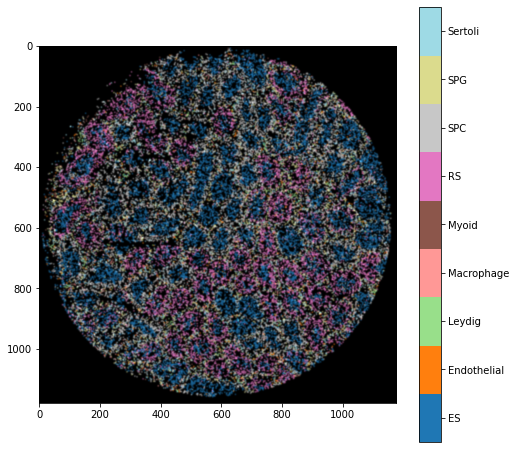

In [7]:
x, fig = sp_imgs[0].to_rgb()
print(x.shape)
fig

### Inspect the content of one sparse_image

Note that initially only the spot dictionary is non-empty

In [8]:
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (31659,)
 y_key <class 'numpy.ndarray'> (31659,)
 cat_key <class 'numpy.ndarray'> (31659,)

-- patch_properties_dict --

-- image_properties_dict --


### Compute the neighborhood composition vectors (ncv) at a given resolution 

Here we compute the features based on the k nearest neighbours. \
The same could be done by providing a radius so that only the neighbours within that radius are used.

In [9]:
for k in (25, 50, 100, 200, 500, 1000):
    sp_imgs[0].compute_ncv(feature_name="ncv_k{}".format(k), k=k)
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (31659,)
 y_key <class 'numpy.ndarray'> (31659,)
 cat_key <class 'numpy.ndarray'> (31659,)
 ncv_k25 <class 'numpy.ndarray'> (31659, 9)
 ncv_k50 <class 'numpy.ndarray'> (31659, 9)
 ncv_k100 <class 'numpy.ndarray'> (31659, 9)
 ncv_k200 <class 'numpy.ndarray'> (31659, 9)
 ncv_k500 <class 'numpy.ndarray'> (31659, 9)
 ncv_k1000 <class 'numpy.ndarray'> (31659, 9)

-- patch_properties_dict --

-- image_properties_dict --


### Compute the Barlow self-supervised features

In [10]:
# Restars the analysis from scratch if necessary
sp_imgs[0].clear(patch_dict=True, image_dict=True)
sp_imgs[0].trim_spot_dictionary(keys="barlow")
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (31659,)
 y_key <class 'numpy.ndarray'> (31659,)
 cat_key <class 'numpy.ndarray'> (31659,)
 ncv_k25 <class 'numpy.ndarray'> (31659, 9)
 ncv_k50 <class 'numpy.ndarray'> (31659, 9)
 ncv_k100 <class 'numpy.ndarray'> (31659, 9)
 ncv_k200 <class 'numpy.ndarray'> (31659, 9)
 ncv_k500 <class 'numpy.ndarray'> (31659, 9)
 ncv_k1000 <class 'numpy.ndarray'> (31659, 9)

-- patch_properties_dict --

-- image_properties_dict --


In [11]:
n_patches_max = 30

sp_imgs[0].compute_patch_features(
    feature_name="barlow", 
    datamodule=dm, 
    model=model, 
    batch_size=64,
    n_patches_max=n_patches_max,
    overwrite=True)

# Note that the patch properties dictionary is not empty
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (31659,)
 y_key <class 'numpy.ndarray'> (31659,)
 cat_key <class 'numpy.ndarray'> (31659,)
 ncv_k25 <class 'numpy.ndarray'> (31659, 9)
 ncv_k50 <class 'numpy.ndarray'> (31659, 9)
 ncv_k100 <class 'numpy.ndarray'> (31659, 9)
 ncv_k200 <class 'numpy.ndarray'> (31659, 9)
 ncv_k500 <class 'numpy.ndarray'> (31659, 9)
 ncv_k1000 <class 'numpy.ndarray'> (31659, 9)

-- patch_properties_dict --
 barlow <class 'numpy.ndarray'> (30, 512)
 barlow_patch_xywh <class 'numpy.ndarray'> (30, 4)

-- image_properties_dict --


Now we transfer the annotation from the patch to the spot level. \
Internally the annotation are first transferred patch -> image  and then image -> spot.

In [12]:
sp_imgs[0].transfer_patch_to_spot(keys_to_transfer=["barlow"], overwrite=True)

# Note that now the the patch properties dictionary is not empty
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (31659,)
 y_key <class 'numpy.ndarray'> (31659,)
 cat_key <class 'numpy.ndarray'> (31659,)
 ncv_k25 <class 'numpy.ndarray'> (31659, 9)
 ncv_k50 <class 'numpy.ndarray'> (31659, 9)
 ncv_k100 <class 'numpy.ndarray'> (31659, 9)
 ncv_k200 <class 'numpy.ndarray'> (31659, 9)
 ncv_k500 <class 'numpy.ndarray'> (31659, 9)
 ncv_k1000 <class 'numpy.ndarray'> (31659, 9)
 barlow <class 'numpy.ndarray'> (31659, 512)

-- patch_properties_dict --
 barlow <class 'numpy.ndarray'> (30, 512)
 barlow_patch_xywh <class 'numpy.ndarray'> (30, 4)

-- image_properties_dict --
 barlow <class 'numpy.ndarray'> (512, 1178, 1178)


### Visualization as a sanity check

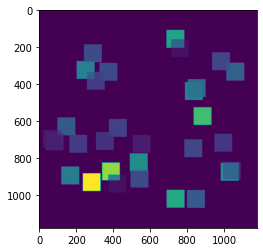

In [13]:
plt.imshow(sp_imgs[0].image_properties_dict["barlow"][0])

# TODO

Look at older notebook. tp_02_validation for a lot of vosualization.
Here we need pca percentile plot in space....

### Export the anndata and write it to file

In [14]:
adata = sp_imgs[0].to_anndata()
adata.write(filename="anndata_with_annotations.h5ad")
adata              

AnnData object with n_obs × n_vars = 31659 × 24450
    obs: 'x', 'y', 'cell_type'
    obsm: 'ncv_k25', 'ncv_k50', 'ncv_k100', 'ncv_k200', 'ncv_k500', 'ncv_k1000', 'barlow'